# Check the GPU

In [1]:
!nvidia-smi

Wed Jun 10 07:37:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries and Functions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import os
import time
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Input, ReLU, Lambda, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Import Resnet9
from MResnet9 import Resnet9, init_pytorch

# Import BatchNorm
from MBatchNorm import BatchNorm

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR
from clr import *

# Setting Hyperparams

In [0]:
# Dictionary of hyperparameters
hparams = {
    'learning_rate' : 0.4,  # fixed learning rate
    'batch_size': 512,  # training batch size
    'momentum' : 0.9, # fixed momentum
    'n_epochs': 24,  # number of epochs to train
    'decay' : 1e-04, # learning rate*batch size
}

# Data Preprocessing

## Downloading Dataset

In [0]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## View Data

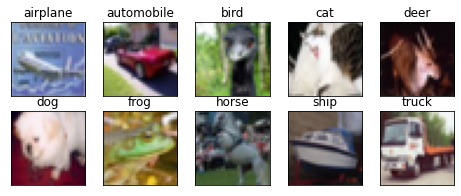

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Image Normalization and One hot encoding

In [0]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [0]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

# 1. Model with Modified Batch Normalization Stride 1 - 50 epochs

## Model Summary

In [9]:
# Model Summary
input_dim = X_train.shape[1:]
# Applying MODIFIED Batch Normalization with default stride 1
net = Resnet9(input_dim, num_classes, hparams=hparams)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        input[0][0]                      
__________________________________________________________________________________________________
batch_norm (BatchNorm)          (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_norm[0][0]                 
______________________________________________________________________________________________

## Model Training

In [0]:
# Write logs in csv
import csv
# field names  
fields = ['Model No.', 'Time(s)', 'Accuracy']  
    
# name of csv file  
filename = "/content/drive/My Drive/BatchNorm Research/30_Sess_logs.csv"

In [11]:
num_sessions = 30

history = []
all_time = []
all_accuracy = []

# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)   
    # writing the fields  
    csvwriter.writerow(fields)  

    # Run for 30 sessions
    for i in range(num_sessions):

      # train the model
      start = time.time()

      # Define model instance
      net = Resnet9(input_dim, num_classes, hparams=hparams)
      print(f"Model-{i} compiled")
      #checkpointer
      checkpointer = ModelCheckpoint(filepath=f"bestmodel_MBN_{i}.h5", verbose=0, 
                                    save_best_only=True, monitor="val_accuracy")
      
      # one cycle lr
      lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                              batch_size = hparams['batch_size'],
                              samples = len(X_train),
                              epochs = hparams['n_epochs'],
                              maximum_momentum = hparams['momentum'],
                              verbose=False)

      # Fit the model
      print(f"Model-{i} is training...")
      hist = net.fit(datagen.flow(X_train, y_train, 
                        batch_size= hparams['batch_size'], 
                        shuffle=True),
                        epochs = hparams['n_epochs'], 
                        steps_per_epoch= np.ceil(X_train.shape[0]/hparams['batch_size']),
                        validation_data=(X_test, y_test),
                        verbose=0,
                        callbacks=[lr_manager, checkpointer])      
      
      history.append(hist)

      end = time.time()
      print (f"Model-{i} took %0.2f seconds to train"%(end - start))
      all_time.append(end-start)

      # Evaluation
      bestmodel = load_model(f"bestmodel_MBN_{i}.h5", custom_objects={'init_pytorch': init_pytorch, "BatchNorm": BatchNorm})
      score= bestmodel.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=0)
      print("Max Validation Accuracy:", score[1]*100, "%\n")
      all_accuracy.append(score[1])

      # Write logs in csv file
      csvwriter.writerow([f"Model-{i}", all_time[i], all_accuracy[i]])  

Model-0 compiled
Model-0 is training...
Model-0 took 270.93 seconds to train
Max Validation Accuracy: 93.32000017166138 %

Model-1 compiled
Model-1 is training...
Model-1 took 268.12 seconds to train
Max Validation Accuracy: 93.44000220298767 %

Model-2 compiled
Model-2 is training...
Model-2 took 268.45 seconds to train
Max Validation Accuracy: 93.55999827384949 %

Model-3 compiled
Model-3 is training...
Model-3 took 267.89 seconds to train
Max Validation Accuracy: 93.15000176429749 %

Model-4 compiled
Model-4 is training...
Model-4 took 268.18 seconds to train
Max Validation Accuracy: 93.33999752998352 %

Model-5 compiled
Model-5 is training...
Model-5 took 267.75 seconds to train
Max Validation Accuracy: 93.48000288009644 %

Model-6 compiled
Model-6 is training...
Model-6 took 267.78 seconds to train
Max Validation Accuracy: 93.4000015258789 %

Model-7 compiled
Model-7 is training...
Model-7 took 267.80 seconds to train
Max Validation Accuracy: 93.55000257492065 %

Model-8 compiled
